## Setup

In [2]:
# Libraries
import pandas as pd
import numpy as np
import gpflow 
import pickle
from helper_functions import *

# Options
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
box_path = '~/Library/CloudStorage/Box-Box/'

In [3]:
# Data
# Read in metabolomics data
# mbx = pd.read_csv('../examples/iHMP/data/iHMP_labeled_metabolomics.csv')
mbx = pd.read_csv(box_path+'/Waveome/data/iHMP/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)
# Only keep metabolites that have at least 20% non-missing values
# mbx_list = mbx_list[(mbx.notna().mean() >= 0.2).values]
mbx = mbx[mbx_list]

# Read in metadata for timing of samples
# meta = pd.read_csv('../examples/iHMP/data/iHMP_metadata.csv')
meta = pd.read_csv(box_path+'/Waveome/data/iHMP/iHMP_metadata.csv')

# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi', 'sccai', 'race', 'sex',
                                                  #'Age at diagnosis', 'consent_age',
                                                  #'site_name'
                                                 ]]
meta.set_index('External ID', inplace=True)

# Combine severity scores
meta['severity'] = np.where(meta['diagnosis'] == 'CD', meta.hbi, meta.sccai)
meta['severity'] = np.where(meta['diagnosis'] == 'nonIBD', 0, meta['severity'])

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Find the max severity day for each ID
max_date = df[['id', 'severity', 'date']].\
    dropna(subset=['severity']).\
    sort_values(['severity', 'date'], ascending=[True, False]).\
    groupby('id').\
    tail(1).\
    drop(columns=['severity']).\
    rename(columns={'date': 'max_severity_date'})

# Merge to get the median date for controls
max_date = max_date.merge(
    right=df.query("diagnosis == 'nonIBD'")[['id', 'date']].\
        groupby('id', as_index=False).\
        apply(lambda x: x.iloc[int(np.floor((len(x)+1)//2))]).\
        rename(columns={'date': 'med_severity_date'}),
    on='id',
    how='left'
)
# Use median date if available, otherwise use computed value
max_date['max_severity_date'] = max_date.med_severity_date.combine_first(max_date.max_severity_date)
# Drop unnecessary column
max_date.drop(columns=['med_severity_date'], inplace=True)

# Merge this back to df
df = pd.merge(df, max_date, on='id')
df['days_from_max_severity'] = (df.date - df.max_severity_date).dt.days
df = df.drop(columns=['max_severity_date'])

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
# df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing severity for the moment
# df = df[df.hbi.notna()]

# Fill in severity scores for individuals, last carry forward 
df['severity'] = df[['id', 'severity']].\
    groupby('id').\
    fillna(method='ffill')
df = df[df.severity.notna()]
df = df.drop(columns=['hbi', 'sccai'])

# Drop UC individuals for now
df = df.query("diagnosis != 'UC'")
df = df.query("diagnosis == 'CD'")
df = df.drop(columns=['diagnosis'])

# Store individual information look up vectors
# Get numerics for each categorical value as well as the lookup index
df['id'], id_map = pd.factorize(df['id'])
# df['diagnosis'], diagnosis_map = pd.factorize(df['diagnosis'])
df['race'], race_map = pd.factorize(df['race'])
df['sex'], sex_map = pd.factorize(df['sex'])
# n_id = df.id.nunique()
# id_list = df.id.unique()
# id_vals = df.id.values
# id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
# df['id'] = id_idx

# Only keep metabolites 
df_original = df.copy()

# Standardize severity and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
df.days_from_max_severity = (df.days_from_max_severity - df.days_from_max_severity.mean())/df.days_from_max_severity.std()
df.severity = (df.severity - df.severity.mean())/df.severity.std()

# Normalize columns
# df.days_from_start = (df.days_from_start.max() - df.days_from_start)/(df.days_from_start.max()-df.days_from_start.min())
# df.hbi = (df.hbi.max() - df.hbi)/(df.hbi.max() - df.hbi.min())
# df.id = (df.id.max() - df.id)/(df.id.max() - df.id.min())
# df.id = (df.id - df.id.mean())/df.id.std()
print(df.shape)
df.head()

# Specify the covariate features of interest
feat_names = col_names = ['id', # 'diagnosis', 
                          'race', 'sex', 
                          'severity', 
                          'days_from_start', 
                          'days_from_max_severity']
df.shape

# Get percent missing for each column and then only flag metabolites with at least 1% observations missing
missing_mbx_list = list(df.drop(columns=feat_names).columns[
    df.drop(columns=feat_names).isna().mean(axis=0) > 0.1
])

# Specify kernels to search over for continuous features
kernel_list = [
    Lin(),
    Poly(),
    gpflow.kernels.SquaredExponential(),
    gpflow.kernels.Matern12(),
    gpflow.kernels.ArcCosine(),
    gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
]

# Number of metabolites
n_met = len(missing_mbx_list)

/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_46225/3083134390.py:17: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(box_path+'/Waveome/data/iHMP/iHMP_metadata.csv')


(257, 557)


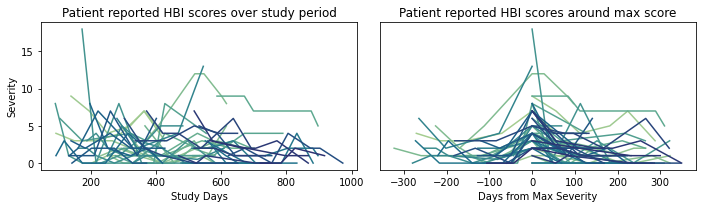

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

# Plot days from start
sns.lineplot(
    x="days_from_start",
    y="severity",
    hue="id",
    #col="diagnosis",
    # kind="line",
    data=df_original,
    palette="crest",
    markers='o',
    legend=False,
    ax=ax[0]
)

# Plot days from max severity
sns.lineplot( # sns.relplot
    x="days_from_max_severity",
    y="severity",
    hue="id",
    #col="diagnosis",
    # kind="line",
    data=df_original,
    palette="crest",
    markers='o',
    legend=False,
    ax=ax[1]
)

# Fix up all of the labels
ax[0].set(ylabel='Severity', xlabel='Study Days', title='Patient reported HBI scores over study period')
ax[1].set(ylabel='', yticks=[], xlabel='Days from Max Severity', title='Patient reported HBI scores around max score')

fig.tight_layout()
fig.savefig("../figures/ihmp_spahetti.png") 
plt.show()

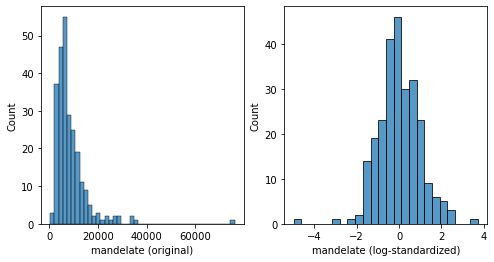

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
sns.histplot(df_original.mandelate, ax=axs[0])
sns.histplot((np.log(df_original.mandelate) - np.log(df_original.mandelate).mean())/
            np.log(df_original.mandelate).std(),
           ax=axs[1])
axs[0].set(xlabel='mandelate (original)')
axs[1].set(xlabel='mandelate (log-standardized)')
fig.savefig("../figures/mandelate_values.png", dpi=800)

## iHMP Stage One Model Search

In [6]:
# feat_names = ['id', 
#               'race', 
#               'sex', 
#               'severity', 
#               'days_from_start', 
#               'days_from_max_severity']

# stage1 = GPKernelSearch(
#     X=df[feat_names],
#     Y=df[missing_mbx_list].notna().astype(float),
#     unit_col='id',
#     categorical_vars=['id', 'race', 'sex'],
#     outcome_likelihood="bernoulli"
# )

# stage1.run_search(
#     kernels=[
#         gpflow.kernels.SquaredExponential(),
#         gpflow.kernels.Matern12(),
#         gpflow.kernels.Polynomial(),
#         gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential()),
#         Lin(),
#             ],
#     random_seed=9102,
#     num_jobs=1
# )

# # Save output
# f = open("ihmp_binomial_models.pkl","wb")
# pickle.dump(stage1, f)
# f.close()

### Stage One Load

In [7]:
# Load output if needed
binomial_models = pickle.load(open("ihmp_binomial_models.pkl", "rb" ))
binomial_dict = {k: v for k,v in zip(missing_mbx_list, binomial_models)}

# Load into GPKS object
stage1 = GPKernelSearch(
    X=df[feat_names],
    Y=df[missing_mbx_list].notna().astype(float),
    unit_col='id',
    categorical_vars=['id', 'race', 'sex'],
    outcome_likelihood='bernoulli'
)

stage1.models = binomial_dict

Text(0.5, 1.0, 'Stage one heatmap of metabolites \nwith kernel components and variance explained')

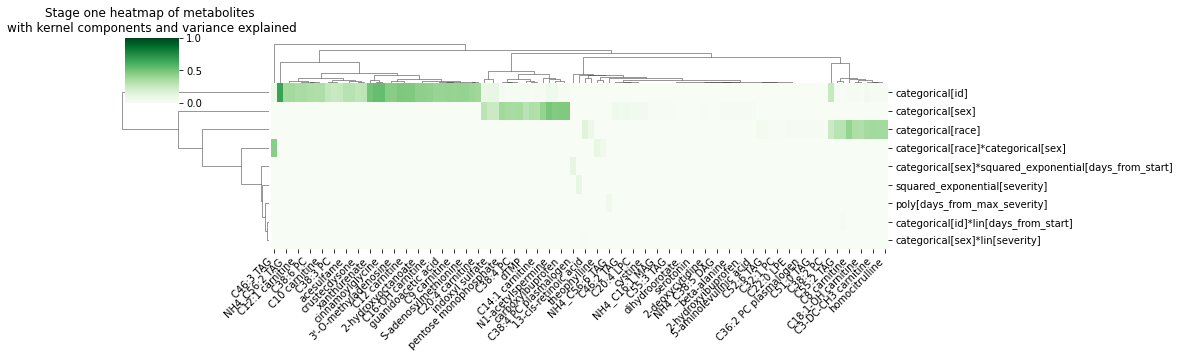

In [8]:
stage1.plot_heatmap(var_cutoff=0, show_vals=False)
plt.title('Stage one heatmap of metabolites \nwith kernel components and variance explained')
plt.savefig("../figures/s1_heatmap.png", bbox_inches='tight')

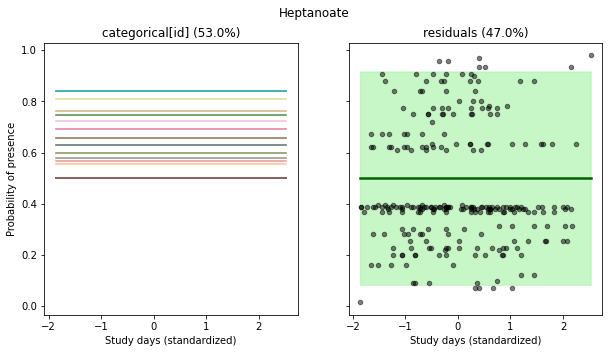

In [9]:
ax = stage1.plot_parts("heptanoate", "days_from_start")
ax[1][0].set_ylabel('Probability of presence')
ax[1][0].set_xlabel('Study days (standardized)')
ax[1][1].set_xlabel('Study days (standardized)')
plt.suptitle('Heptanoate')
plt.savefig("../figures/heptanoate_s1.png")

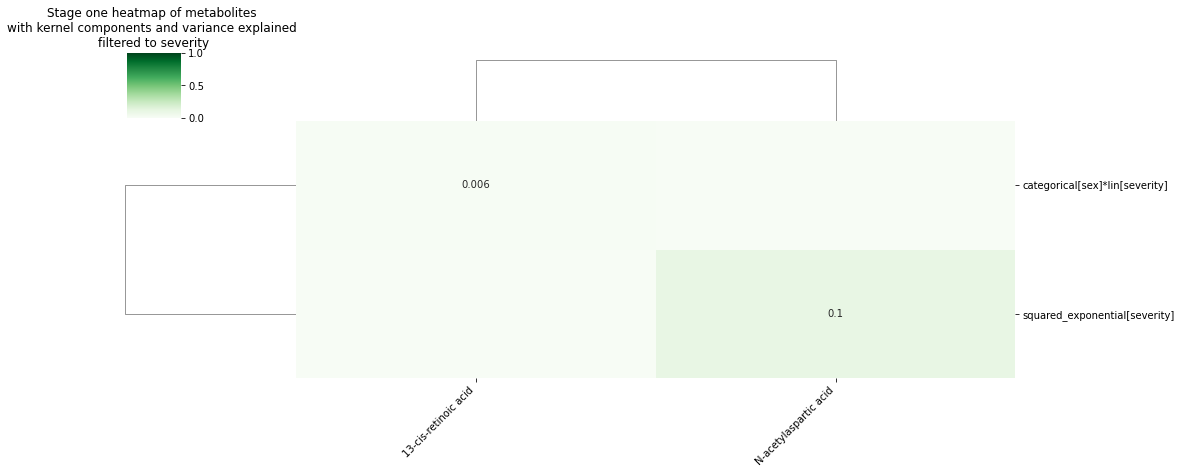

In [10]:
stage1.plot_heatmap(var_cutoff=0, feat="severity")
plt.title('Stage one heatmap of metabolites \nwith kernel components and variance explained \nfiltered to severity')
plt.savefig("../figures/s1_heatmap_severity.png")

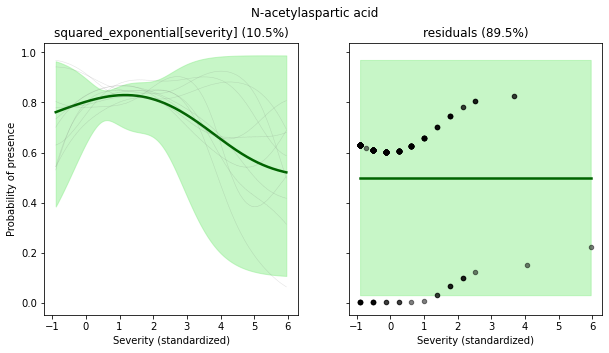

In [11]:
ax = stage1.plot_parts("N-acetylaspartic acid", "severity")
ax[1][0].set_ylabel('Probability of presence')
plt.suptitle('N-acetylaspartic acid')
ax[1][0].set_xlabel('Severity (standardized)')
ax[1][1].set_xlabel('Severity (standardized)')
plt.savefig("../figures/n_acetylaspartic_acid_s1.png")

## iHMP Stage Two Model Search

In [66]:
# # --- RUN THIS IF YOU NEED THE SEARCH OUTPUT AGAIN --- #
# feat_names = ['id',
#               'race',
#               'sex',
#               'severity',
#               'days_from_start',
#               'days_from_max_severity']

# # Standardize the metabolite values
# standardized_df = (np.log(df) - np.log(df).mean())/np.log(df).std()

# stage2 = GPKernelSearch(
#     X=df[feat_names],
#     Y=standardized_df.drop(columns=feat_names),
#     unit_col='id',
#     categorical_vars=['id', 'race', 'sex']
# )

# stage2.run_search(
#     kernels=[
#         gpflow.kernels.SquaredExponential(),
#         gpflow.kernels.Matern12(),
#         Poly(),
#         gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential()),
#         gpflow.kernels.ArcCosine(),
#         Lin(),
#             ],
#     random_seed=9102,
#     num_jobs=6
# )
# # Number of labelled metabolites: 551
# # Estimated time to finish: 6h 53m

# # Save output
# f = open("ihmp_gaussian_models.pkl","wb")
# pickle.dump(stage2, f)
# f.close()

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
Kernel search:   8%|█▉                       | 44/551 [41:11<15:23:53, 109.34s/it]/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Kernel search: 100%|██████████████████████████| 551/551 [6:50:57<00:00, 44.75s/it]


### Stage Two Load

In [72]:
# Load output if needed
stage2 = pickle.load(open("ihmp_gaussian_models.pkl", "rb" ))

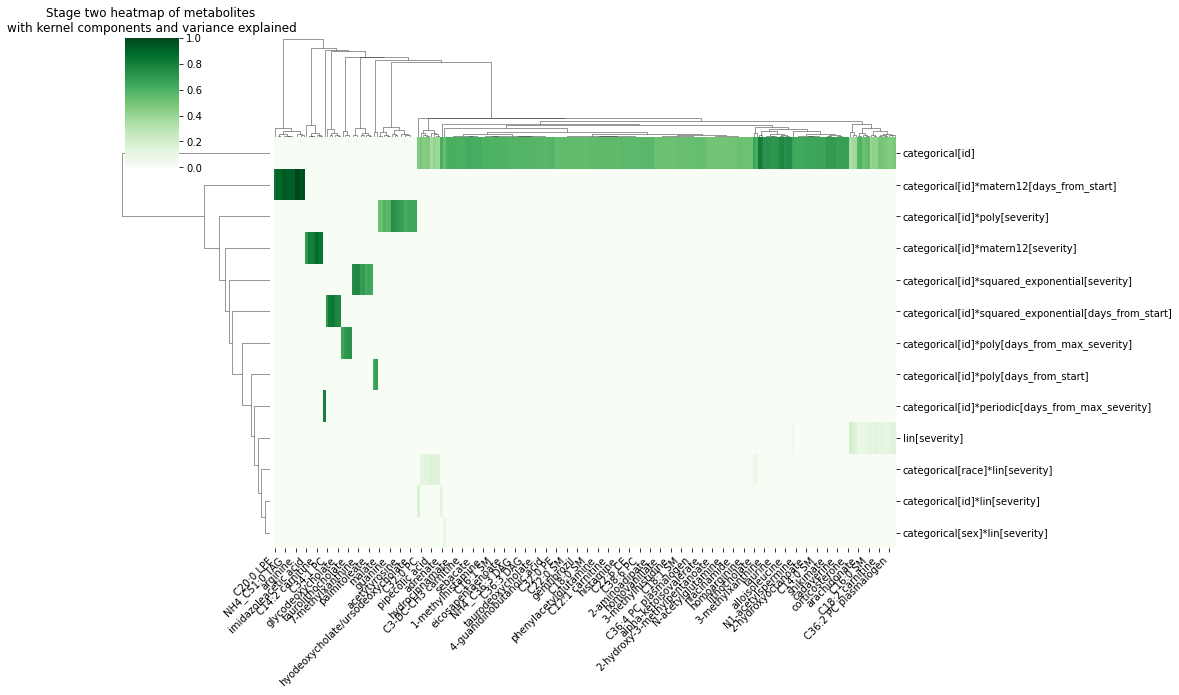

In [18]:
stage2.plot_heatmap(var_cutoff=0.5, show_vals=False, figsize=(15,10))
plt.title('Stage two heatmap of metabolites \nwith kernel components and variance explained')
plt.savefig("../figures/s2_heatmap.png", bbox_inches='tight')

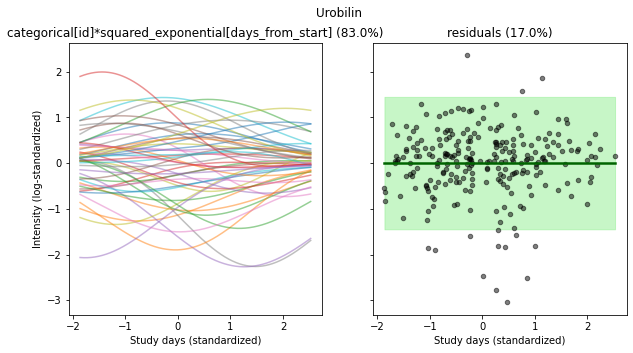

In [68]:
ax = stage2.plot_parts("urobilin", "days_from_start")
ax[1][0].set_ylabel('Intensity (log-standardized)')
plt.suptitle('Urobilin')
ax[1][0].set_xlabel('Study days (standardized)')
ax[1][1].set_xlabel('Study days (standardized)')
plt.savefig("../figures/urobilin_s2.png")

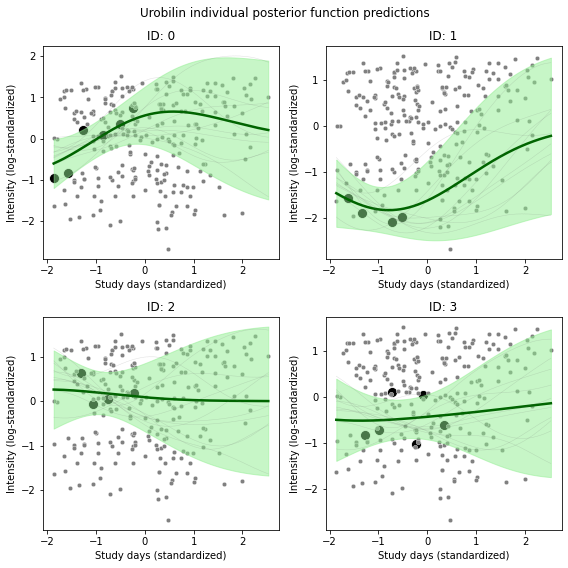

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
stage2.plot_marginal("urobilin", "days_from_start", unit_label=0, ax=axs[0,0])
axs[0,0].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 0')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=1, ax=axs[0,1])
axs[0,1].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 1')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=2, ax=axs[1,0])
axs[1,0].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 2')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=3, ax=axs[1,1])
axs[1,1].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 3')
plt.suptitle('Urobilin individual posterior function predictions')
plt.tight_layout()
plt.savefig("../figures/urobilin_s2_indiv.png", bbox_inches='tight')

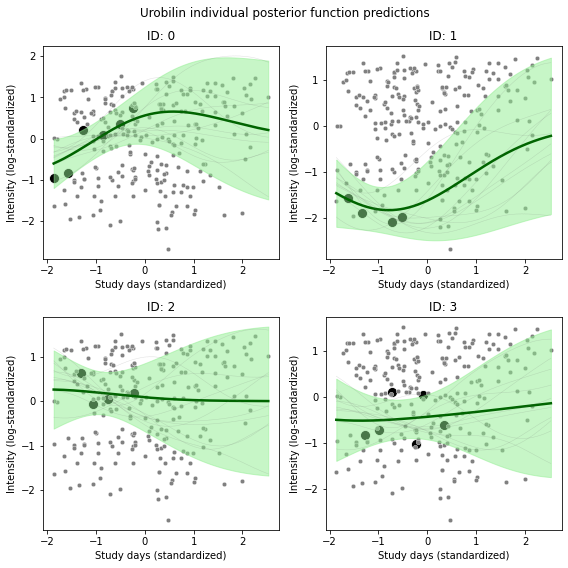

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(8,8))
stage2.plot_marginal("urobilin", "days_from_start", unit_label=0, ax=axs[0,0])
axs[0,0].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 0')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=1, ax=axs[0,1])
axs[0,1].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 1')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=2, ax=axs[1,0])
axs[1,0].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 2')
stage2.plot_marginal("urobilin", "days_from_start", unit_label=3, ax=axs[1,1])
axs[1,1].set(ylabel='Intensity (log-standardized)', xlabel='Study days (standardized)', title='ID: 3')
plt.suptitle('Urobilin individual posterior function predictions')
plt.tight_layout()
plt.savefig("../figures/urobilin_s2_indiv.png", bbox_inches='tight')

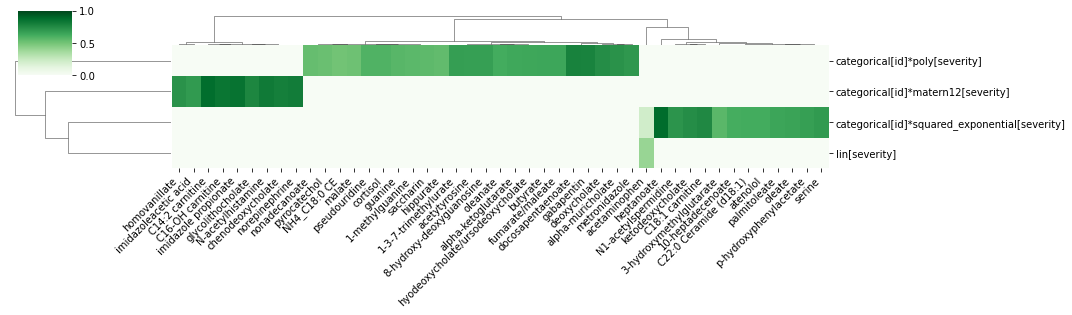

In [26]:
stage2.plot_heatmap(var_cutoff=0.5, feat="severity", show_vals=False)

/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/allen/miniforge3/envs/gpflow/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


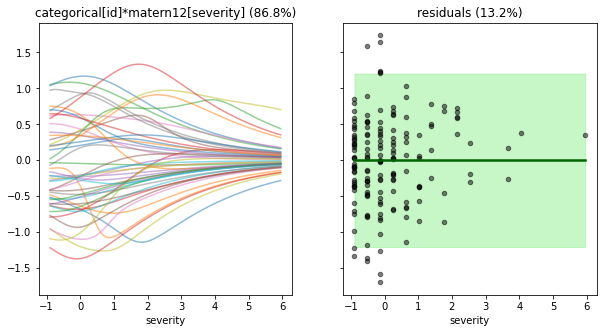

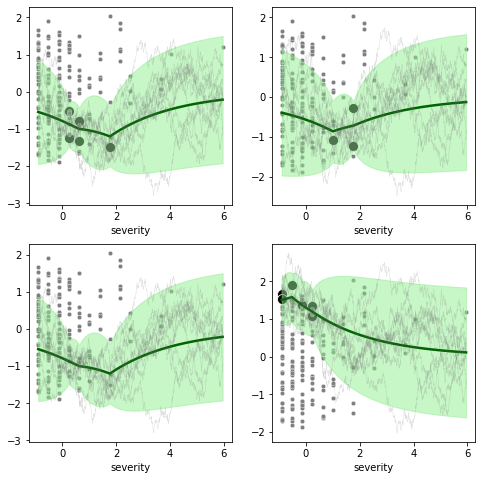

In [75]:
# Save this for later
met = "C14:2 carnitine"
x_var = "severity"
stage2.plot_parts(met, x_var)
fig, axs = plt.subplots(2, 2, figsize=(8,8))
stage2.plot_marginal(met, x_var, unit_label=0, ax=axs[0,0])
stage2.plot_marginal(met, x_var, unit_label=1, ax=axs[0,1])
stage2.plot_marginal(met, x_var, unit_label=2, ax=axs[1,0])
stage2.plot_marginal(met, x_var, unit_label=3, ax=axs[1,1])

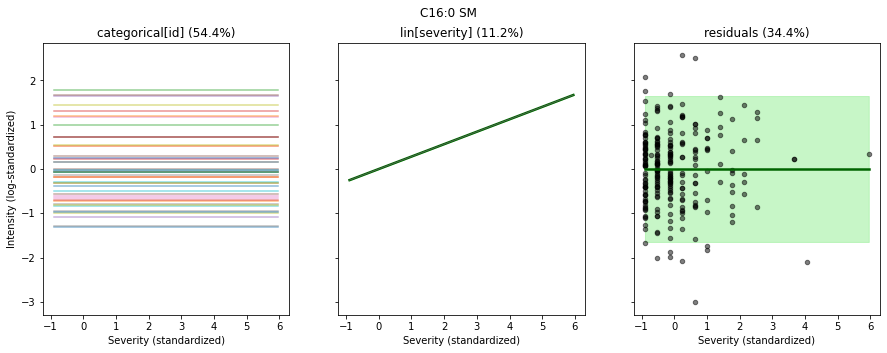

In [76]:
ax = stage2.plot_parts("C16:0 SM", "severity")
ax[1][0].set_ylabel('Intensity (log-standardized)')
plt.suptitle('C16:0 SM')
ax[1][0].set_xlabel('Severity (standardized)')
ax[1][1].set_xlabel('Severity (standardized)')
ax[1][2].set_xlabel('Severity (standardized)')
plt.savefig("../figures/c160_sm_s2.png")

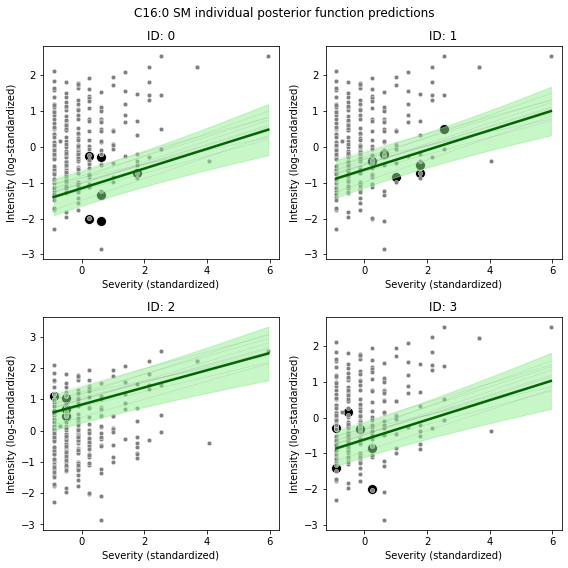

In [77]:
met = "C16:0 SM"
x_var = "severity"
fig, axs = plt.subplots(2, 2, figsize=(8,8))
stage2.plot_marginal(met, x_var, unit_label=0, ax=axs[0,0])
axs[0,0].set(ylabel='Intensity (log-standardized)', xlabel='Severity (standardized)', title='ID: 0')
stage2.plot_marginal(met, x_var, unit_label=1, ax=axs[0,1])
axs[0,1].set(ylabel='Intensity (log-standardized)', xlabel='Severity (standardized)', title='ID: 1')
stage2.plot_marginal(met, x_var, unit_label=2, ax=axs[1,0])
axs[1,0].set(ylabel='Intensity (log-standardized)', xlabel='Severity (standardized)', title='ID: 2')
stage2.plot_marginal(met, x_var, unit_label=3, ax=axs[1,1])
axs[1,1].set(ylabel='Intensity (log-standardized)', xlabel='Severity (standardized)', title='ID: 3')
plt.suptitle('C16:0 SM individual posterior function predictions')
plt.tight_layout()
plt.savefig("../figures/c160_sm_s2_indiv.png", bbox_inches='tight')

In [4]:
stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,Uniform,True,(),float64,0.515648
GPR.kernel.kernels[1].variance,Parameter,Softplus,Uniform,True,(),float64,0.0779675
GPR.likelihood.variance,Parameter,Softplus + Shift,Uniform,True,(),float64,0.412863


### SM Sampling

In [25]:
# %%time
# # Posterior sampling of this metabolite
# hyperp_samps = hmc_sampling(
#     model = stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"],
#     burn_in=2000,
#     samples=2000,
#     random_seed=9102
# )
#
# # Save results
# f = open("sm_hyper_samples_single.pkl","wb")
# pickle.dump(hyperp_samps, f)
# f.close()

CPU times: user 1h 32min 18s, sys: 2min 19s, total: 1h 34min 38s
Wall time: 1h 30min 39s


In [8]:
hyperp_samps = Parallel(n_jobs=4, verbose=10)(delayed(hmc_sampling)(
    model = stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"],
    burn_in=2000,
    samples=2000,
    random_seed=(9012+i),
    step_size=0.1,
    accept_prob=0.9
) for i in range(4))

# # Save results
# f = open("sm_hyper_samples.pkl","wb")
# pickle.dump(hyperp_samps, f)
# f.close()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 92.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 92.7min remaining: 92.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 92.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 92.9min finished


In [78]:
# Read in posterior samples
hyperp_samps = pickle.load(open("sm_hyper_samples.pkl", "rb"))

In [80]:
hyperp_df = pd.melt(
    pd.DataFrame(np.array([x['samples'] for x in hyperp_samps])[:,0,:].T),
    # pd.DataFrame(np.array(hyperp_samps['samples'][0])),
    var_name='chain',
    value_name="categorical[id]"
)

# Add the linear variance parameters
hyperp_df["linear[severity]"] = pd.melt(
    pd.DataFrame(np.array([x['samples'] for x in hyperp_samps])[:,1,:].T),
    # pd.DataFrame(np.array(hyperp_samps['samples'][1])),
    var_name='chain',
    value_name='lin_var'
).lin_var

# Add the likelihood variance parameters
hyperp_df["likelihood variance"] = pd.melt(
    pd.DataFrame(np.array([x['samples'] for x in hyperp_samps])[:,2,:].T),
    # pd.DataFrame(np.array(hyperp_samps['samples'][2])),
    var_name='chain',
    value_name='lik_var'
).lik_var

# Add iteration number
hyperp_df['iter'] = np.tile(np.arange(4000), 4)

In [81]:
hyperp_df.head()

,chain,categorical[id],linear[severity],likelihood variance,iter
0,0,0.536098,4.500056,0.432738,0
1,0,0.663005,4.501152,0.446959,1
2,0,0.650613,4.086942,0.396951,2
3,0,0.459364,4.319340,0.368824,3
4,0,0.369312,4.359418,0.424884,4


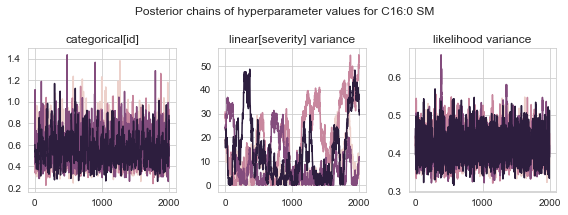

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3))

sns.lineplot(
    x='iter',
    y='categorical[id]',
    hue='chain',
    data=hyperp_df, #.query('iter > 1000'),
    ax=axs[0],
    legend=False
)

sns.lineplot(
    x='iter',
    y='linear[severity]',
    hue='chain',
    data=hyperp_df, #.query('iter > 1000'),
    ax=axs[1],
    legend=False
)

sns.lineplot(
    x='iter',
    y='likelihood variance',
    hue='chain',
    data=hyperp_df, #.query('iter > 1000'),
    ax=axs[2],
    legend=False
)


axs[0].set(title='categorical[id]', xlabel='', ylabel='')
axs[1].set(title='linear[severity] variance', xlabel='', ylabel='')
axs[2].set(title='likelihood variance', xlabel='', ylabel='')
plt.suptitle('Posterior chains of hyperparameter values for C16:0 SM')
plt.tight_layout()
plt.savefig('../figures/posterior_draws_c160_sm.png', bbox_inches='tight')

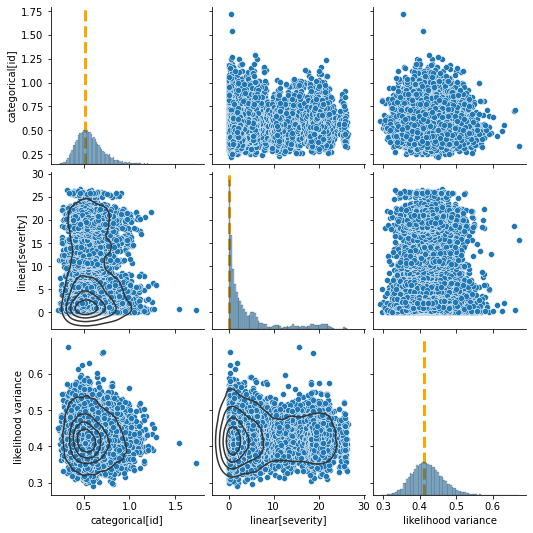

In [89]:
g = sns.pairplot(
    hyperp_df.drop(columns=['chain', 'iter']),
    diag_kws={'alpha': 0.5}
    # plot_kws={'scatter_kws': {'alpha': 0.5}}
)

g.map_lower(sns.kdeplot, levels=5, color=".2")
# g.map_diag(plt.axvline, x=1, ls='--', c='black')
g.axes[0,0].axvline(
    x=stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"].parameters[0].numpy(),
    ls='--',
    lw=3,
    c='orange')
g.axes[1,1].axvline(
    x=stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"].parameters[1].numpy(),
    ls='--',
    lw=3,
    c='orange')
g.axes[2,2].axvline(
    x=stage2.models["C16:0 SM"]["models"]["categorical[0]+lin[3]"]["model"].parameters[2].numpy(),
    ls='--',
    lw=3,
    c='orange')
# g.fig.suptitle('Hyperparameter posterior distributions for C16:0 SM')
# g.fig.savefig('../figures/posterior_hyper_dists_c160_sm.png', bbox_inches='tight')

In [90]:
# Get 95% credible intervals
print(f'Categorical 95% CI: {np.round(np.quantile(hyperp_df["categorical[id]"], q=np.array([0.025, 0.975])), 3)}')
print(f'Linear 95% CI: {np.round(np.quantile(hyperp_df["linear[severity]"], q=np.array([0.025, 0.975])), 3)}')
print(f'Likelihood 95% CI: {np.round(np.quantile(hyperp_df["likelihood variance"], q=np.array([0.025, 0.975])), 3)}')

Categorical 95% CI: [0.346 0.885]
Linear 95% CI: [ 0.069 21.698]
Likelihood 95% CI: [0.346 0.513]


# Previous work below - do not delete! (Not guaranteed to work!!)

In [10]:
# Can we just look at the top five metabolites with the greatest explained variance?
top_five_idx = np.argsort(var_explained)[::-1][:10]

for m in top_five_idx:
    mbx_idx = m
    cur_metabolite = mbx_list.values[mbx_idx] #'heptanoate'#'ketodeoxycholate'#'17-methylstearate'#'chenodeoxycholate'#'mandelate'#'heptanoate'
    cur_kernel = gaussian_models[mbx_idx]['best_model'] #'categorical[0]+linear[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*squared_exponential[1]'#'categorical[0]*linear[2]'
    # observed_data = df[['id', 'hbi', 'days_from_start', cur_metabolite]].dropna()

    print(f"Best kernel: {cur_kernel} for metabolite {cur_metabolite}")

    # # Plot posterior distribution
    # p = gp_predict_fun(
    #     gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
    #     # gaussian_dict[cur_metabolite][cur_kernel][1], 
    #     x_idx=2, 
    #     unit_idx=0,
    #     unit_label=5,
    #     col_names=col_names
    # )
    # Print resulting decomposition
    pred_kernel_parts(
        gaussian_models[mbx_idx]['models'][cur_kernel]['model'],
        # gaussian_dict[cur_metabolite][cur_kernel][1],
        cur_kernel,
        time_idx=4,
        unit_idx=0,
        col_names=feat_names
    );

NameError: name 'var_explained' is not defined

### Clustering Output

In [62]:
def calc_bhattacharyya_dist(model1, model2, X):
    """
    Calculate the Bhattacharyya distance between two resulting MVNormal distributions.
    """
    
    # Calculate means and variances
    mu1, var1 = model1.predict_f(X)
    mu2, var2 = model2.predict_f(X)
    
    # Also calculate covariance matrices
    # Pull kernel covariance matrices
    cov1 = model1.kernel.K(X)
    cov2 = model2.kernel.K(X)
    
    # Then add likelihood noise if necessary
    if model1.name == 'gpr' and model2.name == 'gpr':
        cov1 += tf.linalg.diag(tf.repeat(model1.likelihood.variance, X.shape[0]))
        cov2 += tf.linalg.diag(tf.repeat(model2.likelihood.variance, X.shape[0]))
    
    # Calculate average sigma
    cov_all = (cov1 + cov2)/2.
    
    # After that calculate closed form of Bhattacharyya distance
    dist_b = (#(1/8.) * tf.transpose(mu1 - mu2)@tf.linalg.inv(cov_all)@(mu1 - mu2) + 
              0.5 * np.log(tf.linalg.det(cov_all)/(np.sqrt(tf.linalg.det(cov1)*tf.linalg.det(cov2)))))
    
    return dist_b

In [158]:
stage2.X.head()

,id,race,sex,severity,days_from_start,days_from_max_severity
0,0,0,0,0.626978,-1.854182,-2.218418
1,0,0,0,0.246498,-1.575311,-1.824762
2,0,0,0,0.246498,-1.266562,-1.388929
3,0,0,0,0.626978,-0.858216,-0.812504
4,0,0,0,1.768419,-0.504648,-0.313404


In [378]:
# Make new X matrix to evaluate metabolites
X_continuous = np.array(np.meshgrid(
    np.linspace(stage2.X.severity.min(), stage2.X.severity.max(), 5),
    np.linspace(stage2.X.days_from_start.min(), stage2.X.days_from_start.max(), 5),
    np.linspace(stage2.X.days_from_max_severity.min(), stage2.X.days_from_max_severity.max(), 5)
)).T.reshape(-1, 3)

X_categorical = (stage2
                    .X
                    .iloc[:, stage2.cat_idx]
                    # .drop(columns=stage2.feat_names[stage2.unit_idx])
                    # .drop_duplicates()
                    # .reset_index(drop=True)
                    # .reset_index()
                    # .rename(columns={"index": "id"})
                .to_numpy())

# Now repeat each enough to merge together
X_continuous_rows = X_continuous.shape[0]
X_continuous = np.tile(X_continuous, (X_categorical.shape[0], 1))
X_categorical = np.repeat(X_categorical, X_continuous_rows, axis=0)

# Put together
X_new = np.hstack((X_categorical, X_continuous))


In [379]:
X_new.shape

(32125, 6)

In [380]:
def calc_bhattacharyya_dist(model1, model2, X):
    """
    Calculate the Bhattacharyya distance between two resulting MVNormal distributions.
    """
    
    # Calculate means and variances
    mu1, cov1 = model1.predict_f(X, full_cov=True)
    mu2, cov2 = model2.predict_f(X, full_cov=True)
    
    # Also calculate covariance matrices
    # Pull kernel covariance matrices
    cov1 = model1.kernel.K(X)
    cov2 = model2.kernel.K(X)
    
    # Then add likelihood noise if necessary
    if model1.name == 'gpr' and model2.name == 'gpr':
        cov1 += tf.linalg.diag(tf.repeat(model1.likelihood.variance, X.shape[0]))
        cov2 += tf.linalg.diag(tf.repeat(model2.likelihood.variance, X.shape[0]))
        
    cov1 += tf.linalg.diag(tf.repeat(f64(1e-1), X.shape[0]))
    cov2 += tf.linalg.diag(tf.repeat(f64(1e-1), X.shape[0]))
        
    # Calculate average sigma
    cov_all = (cov1 + cov2)/2.
    
    print(tf.linalg.det(cov1))
    
    # After that calculate closed form of Bhattacharyya distance
    dist_b = ((1/8.) * tf.transpose(mu1 - mu2)@tf.linalg.inv(cov_all)@(mu1 - mu2) + 
              0.5 * np.log(tf.linalg.det(cov_all)/(np.sqrt(tf.linalg.det(cov1)*tf.linalg.det(cov2)))))
    
    return dist_b

In [381]:
[stage2.models[x]["best_model"] for x in stage2.models.keys()][20:40]

['categorical[0]',
 'categorical[0]*squared_exponential[3]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]+lin[3]',
 'categorical[0]*squared_exponential[4]',
 'categorical[0]+lin[3]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]+lin[3]',
 'categorical[0]']

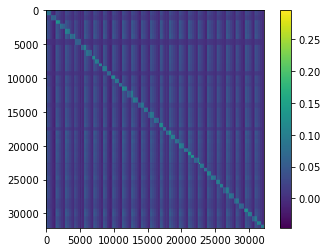

In [382]:
m1 = (stage2.
    models[stage2.out_names[38]]["models"]
    [stage2.models[stage2.out_names[38]]["best_model"]]["model"])
plt.imshow(m1.predict_f(X_new, full_cov=True)[1].numpy()[0,:,:])
plt.colorbar()

In [383]:
tf.linalg.det(m1.kernel.K(X_new) + tf.linalg.diag(tf.repeat(m1.likelihood.variance, X_new.shape[0])))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

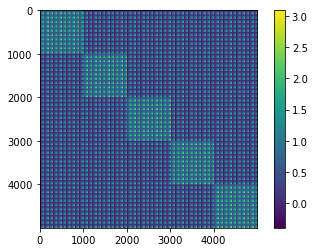

In [362]:
plt.imshow(m1.kernel.K(X_new))
plt.colorbar()

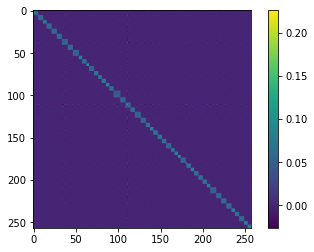

In [363]:
plt.imshow(m1.predict_f(stage2.X.to_numpy().reshape(-1, 6), full_cov=True)[1].numpy()[0,:,:])
plt.colorbar()

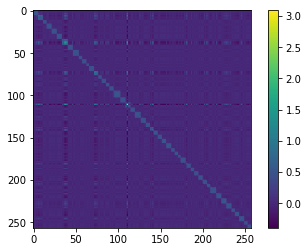

In [364]:
plt.imshow(m1.kernel.K(stage2.X.to_numpy().reshape(-1, 6)).numpy())
plt.colorbar()

In [365]:
%%time
met_dists2 = np.repeat(np.nan, len(stage2.out_names)**2).reshape(-1, len(stage2.out_names))
for i, name1 in enumerate(stage2.out_names[:5]):
    for j, name2 in enumerate(stage2.out_names[i:5]):
        # print(i, name1, j, name2)
        cur_dist = calc_bhattacharyya_dist(
            model1=stage2.models[name1]["models"][stage2.models[name1]["best_model"]]["model"],
            model2=stage2.models[name2]["models"][stage2.models[name2]["best_model"]]["model"],
            # X=stage2.X.to_numpy().reshape(-1, 1)
            X=X_new
        )
        
        # Set distance to zero if negative
        if cur_dist < 0: cur_dist = 0
        
        met_dists2[i, (i+j)] = cur_dist
        met_dists2[(i+j), i] = cur_dist
    
    if i % 10 == 0:
        print(f'Finished output {i}')

tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)


KeyboardInterrupt: 

In [355]:
met_dists2

array([[0.        , 0.2782967 , 7.07259664, ...,        nan,        nan,
               nan],
       [0.2782967 , 0.        , 8.91326839, ...,        nan,        nan,
               nan],
       [7.07259664, 8.91326839,        inf, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

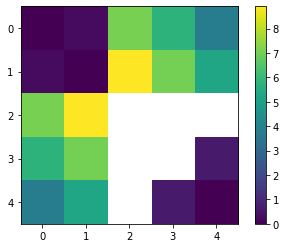

In [356]:
plt.imshow(met_dists2[:5, :5])
plt.colorbar()

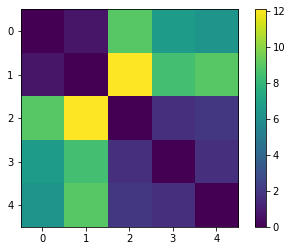

In [271]:
plt.imshow(met_dists2[:5, :5])
plt.colorbar()

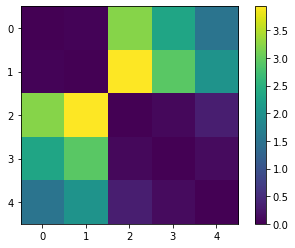

In [205]:
plt.imshow(met_dists2[:5, :5])
plt.colorbar()

In [29]:
%%time
met_dists = np.repeat(np.nan, len(stage2.out_names)**2).reshape(-1, len(stage2.out_names))
for i, name1 in enumerate(stage2.out_names):
    for j, name2 in enumerate(stage2.out_names[i:]):
        # print(i, name1, j, name2)
        cur_dist = calc_bhattacharyya_dist(
            model1=stage2.models[name1]["models"][stage2.models[name1]["best_model"]]["model"],
            model2=stage2.models[name2]["models"][stage2.models[name2]["best_model"]]["model"],
            X=stage2.X.to_numpy().reshape(-1, 6)
        )
        
        # Set distance to zero if negative
        if cur_dist < 0: cur_dist = 0
        
        met_dists[i, (i+j)] = cur_dist
        met_dists[(i+j), i] = cur_dist
    
    if i % 10 == 0:
        print(f'Finished output {i}')

Finished output 0
Finished output 10
Finished output 20
Finished output 30
Finished output 40
Finished output 50
Finished output 60
Finished output 70
Finished output 80
Finished output 90
Finished output 100
Finished output 110
Finished output 120
Finished output 130
Finished output 140
Finished output 150
Finished output 160
Finished output 170
Finished output 180
Finished output 190
Finished output 200
Finished output 210
Finished output 220
Finished output 230
Finished output 240
Finished output 250
Finished output 260
Finished output 270
Finished output 280
Finished output 290
Finished output 300
Finished output 310
Finished output 320
Finished output 330
Finished output 340
Finished output 350
Finished output 360
Finished output 370
Finished output 380
Finished output 390
Finished output 400
Finished output 410
Finished output 420
Finished output 430
Finished output 440
Finished output 450
Finished output 460
Finished output 470
Finished output 480
Finished output 490
Finished ou

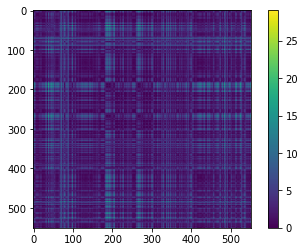

In [31]:
plt.imshow(met_dists)
plt.colorbar()

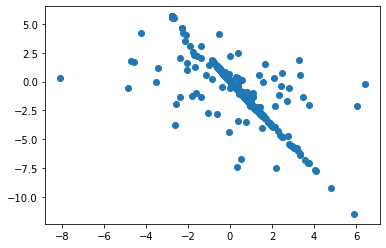

In [38]:
# Multidimensional scaling
from sklearn.manifold import MDS

md_scaling = MDS(dissimilarity="precomputed")
met_scaling = md_scaling.fit_transform(met_dists)

plt.plot(met_scaling[:, 0], met_scaling[:, 1], 'o')

In [55]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

agg_clust = AgglomerativeClustering(affinity="precomputed", linkage="single")
agg_clust.fit(met_dists)

AgglomerativeClustering(affinity='precomputed', linkage='single')

In [52]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

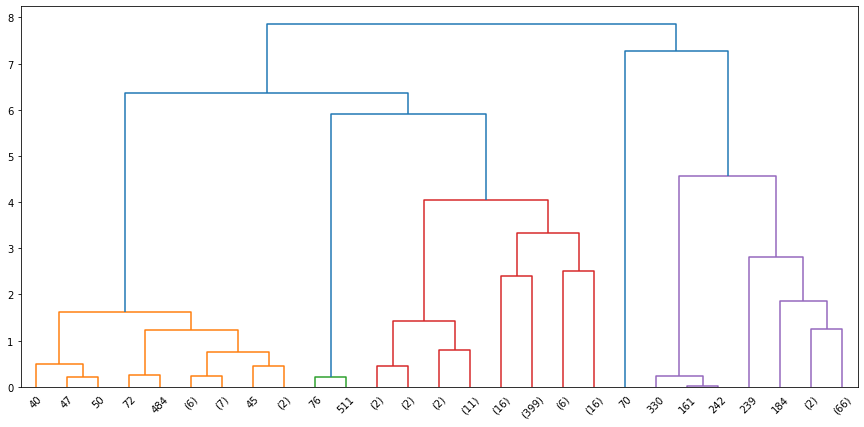

In [92]:
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

fig, axes = plt.subplots(1, 1, figsize=(15,7))

dend_out = dendrogram(
    hierarchy.linkage(
        squareform(met_dists),
        method='centroid'
    ),
    truncate_mode='level',
    p=5,
);

In [97]:
from scipy.cluster.hierarchy import centroid
centroid(squareform(met_dists))

array([[ 267.        ,  275.        ,    0.        ,    2.        ],
       [ 166.        ,  220.        ,    0.        ,    2.        ],
       [ 346.        ,  400.        ,    0.        ,    2.        ],
       ...,
       [1086.        , 1097.        ,    6.36220254,  477.        ],
       [  70.        , 1096.        ,    7.2661962 ,   74.        ],
       [1098.        , 1099.        ,    7.8498687 ,  551.        ]])

In [98]:
from scipy.cluster.hierarchy import fcluster

cluster_ids = fcluster(hierarchy.linkage(
        squareform(met_dists),
        method='centroid'
    ),
        criterion='maxclust',
        t=5)

In [102]:
np.argwhere(cluster_ids == 5)[0]

array([70])

In [106]:
mbx_list[np.argwhere(cluster_ids == 5)[0]].values[0]

'hydrochlorothiazide'

In [110]:
# What does cluster 5 look like?
stage2.models[mbx_list[np.argwhere(cluster_ids == 5)[0]].values[0]]["best_model"]

'constant'

In [120]:
# What about cluster 1?
for idx in np.argwhere(cluster_ids == 1).flatten():
    met = mbx_list[idx]
    mod = replace_kernel_variables(stage2.models[met]["best_model"], feat_names)
    print(f'{met}, model: {mod}')

docosapentaenoate, model: categorical[id]
adrenate, model: categorical[id]+categorical[id]*lin[severity]
lithocholate, model: categorical[id]+categorical[race]*lin[severity]
deoxycholate, model: categorical[id]*poly[severity]
alpha-muricholate, model: categorical[id]*poly[severity]
cetrizine, model: categorical[id]
C38:3 PC, model: categorical[id]
4-hydroxybenzeneacetonitrile, model: categorical[id]
phenylacetate, model: categorical[id]+categorical[race]*lin[severity]
pseudouridine, model: categorical[id]
tartarate, model: constant
cytidine, model: categorical[id]
glutamine, model: categorical[id]*matern12[days_from_start]
tryptophan, model: categorical[id]
taurine, model: categorical[id]
carnitine, model: categorical[id]
C5 carnitine, model: categorical[id]
C12:1 carnitine, model: categorical[id]
beta-guanidinopropionic acid, model: categorical[id]
biotin, model: categorical[id]
cadaverine, model: categorical[id]


In [121]:
# What about cluster 1?
for idx in np.argwhere(cluster_ids == 2).flatten():
    met = mbx_list[idx]
    mod = replace_kernel_variables(stage2.models[met]["best_model"], feat_names)
    print(f'{met}, model: {mod}')

acetytyrosine, model: categorical[id]*poly[severity]
4-guanidinobutanoic acid, model: categorical[id]


In [128]:
for idx in np.argwhere(cluster_ids == 4).flatten():
    met = mbx_list[idx]
    mod = replace_kernel_variables(stage2.models[met]["best_model"], feat_names)
    print(f'{met}, model: {mod}')

2-hydroxyibuprofen, model: constant
furosemide, model: constant
carnosol, model: constant
carnosol_isomer, model: constant
oxypurinol, model: constant
acesulfame, model: constant
13-cis-retinoic acid, model: constant
C20:4 LPC, model: constant
C20:3 LPC, model: constant
C22:6 LPC, model: constant
C20:4 LPE, model: constant
C20:3 CE, model: categorical[id]*lin[days_from_start]
C18:0 MAG, model: constant
C44:2 TAG, model: constant
C44:1 TAG, model: categorical[id]*periodic[days_from_max_severity]
C44:0 TAG, model: constant
C45:0 TAG, model: constant
C46:3 TAG, model: constant
C46:2 TAG, model: constant
C46:1 TAG, model: constant
C48:4 TAG, model: constant
C48:3 TAG, model: constant
C48:2 TAG, model: constant
C48:1 TAG, model: constant
C50:5 TAG, model: constant
C50:4 TAG, model: constant
C51:3 TAG, model: constant
C51:1 TAG, model: constant
C51:0 TAG, model: constant
C52:7 TAG, model: constant
C54:1 TAG, model: constant
C56:2 TAG, model: constant
C56:1 TAG, model: constant
NH4_C18:0 CE, 

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'categorical[id]*poly[severity] (57.0%)'}, xlabel='severity'>,
        <AxesSubplot:title={'center':'residuals (43.0%)'}, xlabel='severity'>],
       dtype=object))

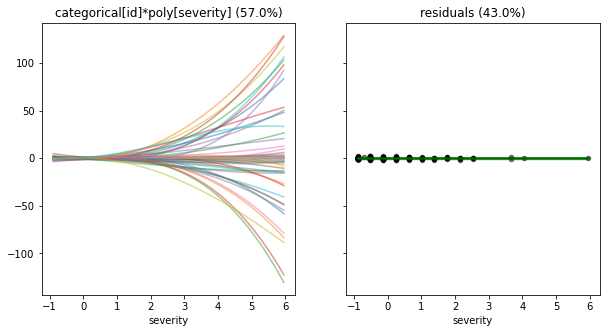

In [129]:
stage2.plot_parts("guanine", "severity")

### Older clustering ideas

In [2]:
gaussian_models = pickle.load(open("ihmp_gaussian_models.pkl", "rb" ))

In [3]:
[x['best_model'] for x in gaussian_models[:10]]

['categorical[0]',
 'categorical[0]*squared_exponential[4]',
 'categorical[0]*matern12[5]+categorical[3]*linear[4]',
 'categorical[0]*squared_exponential[5]',
 'categorical[0]*polynomial[4]',
 'categorical[0]*matern12[5]+categorical[1]*linear[4]',
 'categorical[0]+categorical[2]*linear[6]',
 'categorical[0]',
 'categorical[0]',
 'categorical[0]']

In [4]:
np.unique([i for s in [x['best_model'].split('+') for x in gaussian_models[:10]] for i in s])

array(['categorical[0]', 'categorical[0]*matern12[5]',
       'categorical[0]*polynomial[4]',
       'categorical[0]*squared_exponential[4]',
       'categorical[0]*squared_exponential[5]',
       'categorical[1]*linear[4]', 'categorical[2]*linear[6]',
       'categorical[3]*linear[4]'], dtype='<U37')

In [5]:
# Go through all fitted models and pull off hyperparameter values
param_list = []
for i in range(len(gaussian_models)):
    # print(i)
    # Grab current kernel
    cur_kern = gaussian_models[i]['models'][gaussian_models[i]['best_model']]['kernel']
    # Check if it has multiple components (or sub kernels of +/*)
    if hasattr(cur_kern, 'kernels'):
        k_done = 0
        sub_group = []
        # If so then go through each sub component
        while k_done < len(cur_kern.kernels):
            if cur_kern.name == 'product':
                sub_group += [x.numpy().item() for x in cur_kern.kernels[k_done].parameters]
            else:
                param_list += [[x.numpy().item() for x in cur_kern.kernels[k_done].parameters]]
            k_done += 1
        # Attach product components together in one group
        if cur_kern.name == 'product':
            param_list += [sub_group]
    # Otherwise there is only one kernel component and therefore just pull of specific value
    else:
        param_list += [[x.numpy().item() for x in cur_kern.parameters]]
    

In [6]:
# Split up kernel names by additive components
kernels = [x['best_model'].split('+') for x in gaussian_models]
# Get individual lengths of each model
kernel_lengths = [len(x) for x in kernels]
# Flatten this list
kernels_sep = [item for sublist in kernels for item in sublist]
# Get number of unique kernel components as columns for parameter array 
distinct_kernels, kernel_idx = np.unique(kernels_sep, return_index=True)
param_lengths = [len(param_list[x]) for x in kernel_idx]
parameter_array = np.zeros(shape=(len(gaussian_models), sum(param_lengths)))

In [7]:
parameter_array.shape

(587, 125)

In [8]:
m_ = 0  # Set model row indicator
cs_param_lengths = np.cumsum(param_lengths)
for i in range(len(param_list)):

    # Figure out if we need to go to the next row in the matrix
    if i == np.cumsum(kernel_lengths)[m_]:
        m_ += 1

    # Get next kernel component
    kern_ = kernels_sep[i]

    # Get kernel lookup information
    k_idx = np.where(kern_ == distinct_kernels)[0].item()

    # Find the length of number of parameters to fill in
    # p_length_ = len(param_list[kernel_idx[k_idx]])
    if k_idx == 0:
        start_idx = 0
    else:
        start_idx = cs_param_lengths[k_idx-1]
    # if k_idx == len(param_lengths):
        # end_idx = sum(param_lengths)
    # else:
    end_idx = cs_param_lengths[k_idx]

    # Set values in the parameter array
    # print(f"Index values from {start_idx} to {end_idx}, and filling in {param_list[i]}")
    parameter_array[m_, start_idx:end_idx] = param_list[i]


In [9]:
parameter_array.shape

(587, 125)

In [10]:
# Now add likelihood variance column for all models
lik_vars = [x['models'][x['best_model']]['model'].likelihood.variance.numpy().item() for x in gaussian_models]

parameter_array = np.hstack((parameter_array, np.array(lik_vars).reshape(-1, 1)))

In [11]:
parameter_array.shape

(587, 126)

In [12]:
np.where(parameter_array.std(axis=0) == 0)

# Drop this column because only one value with really small number 
parameter_array = parameter_array[:, parameter_array.std(axis=0)>0]
parameter_array.shape

(587, 125)

In [13]:
parameter_array[:10, :5]

array([[0.39088186, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.47556465, 0.        , 0.        , 0.        , 0.        ],
       [0.42843754, 0.        , 0.        , 0.        , 0.        ],
       [0.22176948, 0.        , 0.        , 0.        , 0.        ],
       [0.1438583 , 0.        , 0.        , 0.        , 0.        ]])

In [14]:
# Scale for PCA and clustering
scaled_parameter_array = (parameter_array - parameter_array.mean(axis=0))/parameter_array.std(axis=0)

(array([586.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.04130962,  2.38356503,  4.80843968,  7.23331433,  9.65818898,
        12.08306363, 14.50793828, 16.93281293, 19.35768758, 21.78256222,
        24.20743687]),
 <BarContainer object of 10 artists>)

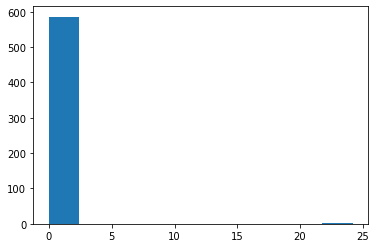

In [15]:
plt.hist(scaled_parameter_array[:, 100])

In [16]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_parameter_array)

PCA()

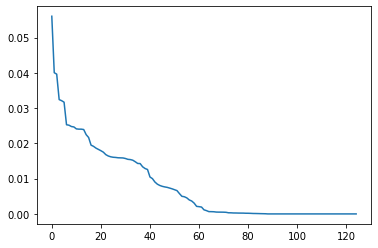

In [17]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

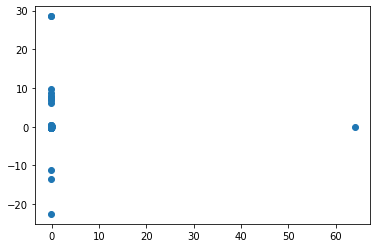

In [18]:
# Plot
scaled_pca = pca.transform(scaled_parameter_array)
plt.plot(scaled_pca[:, 0], scaled_pca[:, 1], 'o')

In [19]:
# Now perform clustering
from sklearn.mixture import GaussianMixture
for nc in range(2, 50, 5):
    gm = GaussianMixture(n_components=nc, random_state=9102, n_init=5).fit(parameter_array)
    print(f"Number of components: {nc}, BIC = {gm.bic(parameter_array)}")

Number of components: 2, BIC = -291465.78238978836
Number of components: 7, BIC = -77201.31885741436
Number of components: 12, BIC = 139473.7875842813
Number of components: 17, BIC = 286848.7078928938
Number of components: 22, BIC = 480219.15027477907
Number of components: 27, BIC = 636656.2865123656
Number of components: 32, BIC = 916339.7207703879
Number of components: 37, BIC = 1079272.256440338
Number of components: 42, BIC = 1390528.3933994952
Number of components: 47, BIC = 1581523.4776501616


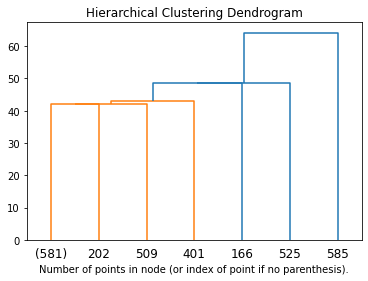

In [22]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(scaled_parameter_array)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [19]:
latent_dim = 2  # number of latent dimensions
num_inducing = 10  # number of inducing pts
num_data = scaled_parameter_array.shape[0]  # number of data points

In [20]:
from gpflow.utilities import ops
import tensorflow as tf
from gpflow.config import default_float
X_mean_init = ops.pca_reduce(scaled_parameter_array, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

In [21]:
np.random.seed(1)  # for reproducibility
inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

In [22]:
lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.Matern12(lengthscales=lengthscales)

In [52]:
# gplvm = gpflow.models.BayesianGPLVM(
#     scaled_parameter_array,
#     X_data_mean=X_mean_init,
#     X_data_var=X_var_init,
#     kernel=kernel,
#     inducing_variable=inducing_variable,
# )
# # Instead of passing an inducing_variable directly, we can also set the num_inducing_variables argument to an integer, which will randomly pick from the data.

gplvm = gpflow.models.GPLVM(
    data=scaled_parameter_array,
    latent_dim=2,
    kernel=gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscales))
)

In [53]:
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(10000)
opt.minimize(
    gplvm.training_loss,
    method="BFGS",
    variables=gplvm.trainable_variables,
    options=dict(maxiter=maxiter),
)

      fun: -53734.88442309209
 hess_inv: array([[ 1.70372828e-03,  3.56213414e-08,  1.70358624e-03, ...,
        -5.97819150e-07,  3.24879133e-07,  2.31086871e-06],
       [ 3.56079899e-08,  1.70373407e-03,  4.06449580e-08, ...,
        -1.73357756e-06,  2.73496155e-07,  5.08710062e-06],
       [ 1.70358624e-03,  4.00252286e-08,  1.70375023e-03, ...,
        -5.52643969e-07, -1.25554529e-07, -1.10888696e-06],
       ...,
       [-6.01513771e-07, -1.75515859e-06, -5.63174999e-07, ...,
         4.24953729e-05,  2.54639990e-05, -7.00192011e-05],
       [ 3.38278981e-07,  2.38452435e-07, -1.77928526e-07, ...,
         2.60136488e-05,  2.85610301e-04,  8.00247282e-06],
       [ 2.31865733e-06,  4.98787056e-06, -1.08738208e-06, ...,
        -6.75674521e-05,  9.04085312e-06,  7.70119254e-04]])
      jac: array([ 5.36552964e+05, -1.72610030e+05, -1.38357222e+04, ...,
       -3.23356434e+01,  2.63110154e+00,  2.50630783e-01])
  message: 'Desired error not necessarily achieved due to precision l

In [54]:
gplvm

name,class,transform,prior,trainable,shape,dtype,value
GPLVM.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,2.2942249441084757
GPLVM.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,"(2,)",float64,[0.01576402 0.07998555]
GPLVM.kernel.period,Parameter,Softplus,,True,(),float64,0.4674368092844242
GPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0000377813490493e-06
GPLVM.data[0],Parameter,Identity,,True,"(587, 2)",float64,"[[-2.42622361e-01, 1.32394405e-01..."


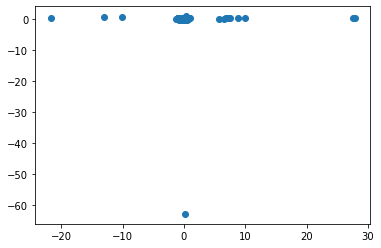

In [55]:
plt.scatter(gplvm.data[0][:, 0], gplvm.data[0][:, 1])

In [35]:
gplvm_X_mean = gplvm.X_data_mean.numpy()
plt.scatter(gplvm_X_mean[:, 0], gplvm_X_mean[:, 1])

AttributeError: 'GPLVM' object has no attribute 'X_data_mean'

In [29]:
# ICA
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=2,
        random_state=0)
X_transformed = transformer.fit_transform(scaled_parameter_array)
X_transformed.shape

(587, 2)

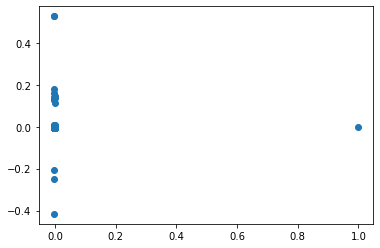

In [30]:
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

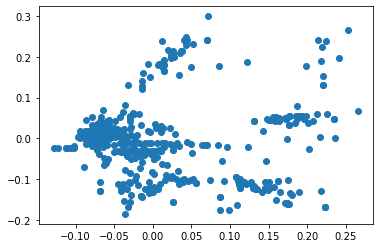

In [32]:
# Kernel PCA
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=10, kernel='sigmoid')
X_transformed = transformer.fit_transform(scaled_parameter_array)
X_transformed.shape
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

## Exploration

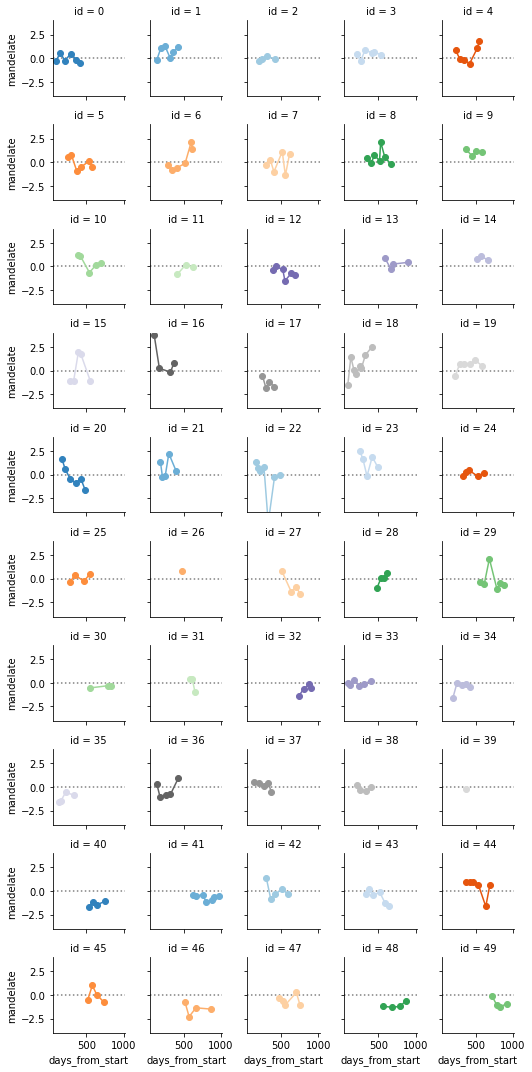

In [78]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df[['id', 'days_from_start', 'mandelate']].sort_values(by=['id', 'days_from_start']), 
                     col="id", hue="id", palette="tab20c",
                     col_wrap=5, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "days_from_start", "mandelate", marker="o")

# Adjust the tick positions and labels
grid.set(ylim=(-4, 4))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

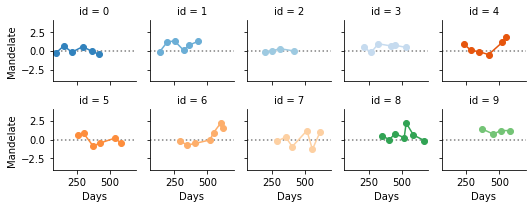

In [393]:
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid((df_original[['id', 'days_from_start', 'mandelate']]
                      .sort_values(by=['id', 'days_from_start'])
                      .assign(mandelate = 
                              lambda x: ((np.log(x.mandelate) - np.log(x.mandelate).mean())/
                                         np.log(x.mandelate).std()))
                      .query("id < 10")), 
                     col="id", hue="id", palette="tab20c",
                     col_wrap=5, height=1.5)

# Draw a horizontal line to show the starting point
grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "days_from_start", "mandelate", marker="o")

# Adjust the tick positions and labels
grid.set(ylim=(-4, 4), xlabel='Days', ylabel='Mandelate')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

grid.fig.savefig("../figures/longitudinal_samples.png") 

## Reversing question - HBI output 

Flip the X and Y search to find relationships with HBI

<AxesSubplot:>

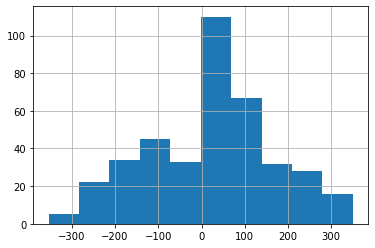

In [6]:
df_original.days_from_max_severity.hist()

<AxesSubplot:>

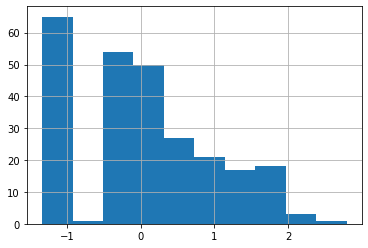

In [13]:
df_cd = df_original.query("diagnosis == 0")
((np.log(df_cd.severity+1) - np.log(df_cd.severity+1).mean())/np.log(df_cd.severity+1).std()).hist()

<AxesSubplot:>

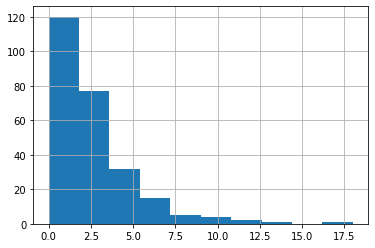

In [14]:
df_cd.severity.hist()

In [15]:
hbi_ard = gpflow.models.GPR(
    data=(df_original.drop(['hbi', 'days_from_max_hbi'], axis=1).iloc[:, :10].fillna(0).astype(float).to_numpy(),
          df_original.days_from_max_hbi.astype(float).to_numpy().reshape(-1, 1)),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=10*[1.])
)
opt_results = gpflow.optimizers.Scipy().minimize(
    hbi_ard.training_loss,
    hbi_ard.trainable_variables
)
hbi_ard

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,10385.777714315547
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,10385.784876295256


<AxesSubplot:>

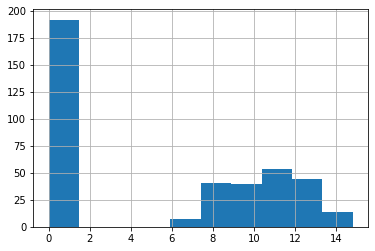

In [20]:
np.log(df_original['C14:0 SM'].fillna(0) + 1).hist()

In [28]:
# Fill in zeros and transform input metabolite data
df_transform = df_original.copy()
df_transform.iloc[:, 5:-2] = np.log(df.iloc[:, 5:-2].fillna(0) + 1)
df_transform['days_from_start'] = df['days_from_start']

In [29]:
df_transform.head()

,id,diagnosis,race,sex,severity,12.13-diHOME,9.10-diHOME,caproate,heptanoate,hydrocinnamate,...,C18:1 LPC plasmalogen,C18:0 LPE-A,C18:0 LPE-B,C22:6 LPE,sphingosine-isomer1,sphingosine-isomer2,sphingosine-isomer3,C14:0 SM,days_from_start,days_from_max_severity
0,0,0,0,0,4.0,13.756341,14.165077,7.693937,0.0,10.550093,...,13.025167,16.117889,15.090683,14.541445,19.430045,18.730814,19.171657,10.500372,-1.989274,-271
1,0,0,0,0,3.0,13.278907,14.486221,7.743270,0.0,11.148737,...,11.780951,16.608835,16.393989,15.307782,18.611757,17.993664,19.524434,10.850851,-1.712809,-215
2,0,0,0,0,3.0,13.227512,13.513712,6.508769,0.0,9.188197,...,8.232440,15.290552,14.572059,16.167979,19.109628,18.483299,18.587746,0.000000,-1.406722,-153
3,0,0,0,0,4.0,13.751161,13.818143,7.167038,0.0,9.749637,...,9.823416,15.011445,14.658513,14.257084,19.051814,18.391969,18.094284,0.000000,-1.001898,-71
4,0,0,0,0,7.0,14.067175,14.189521,7.979681,0.0,10.048626,...,0.000000,15.934634,14.743433,15.404968,18.843591,18.192024,19.235215,8.734399,-0.651379,0


In [3]:
%%time
kernel_list = [gpflow.kernels.SquaredExponential(),
               gpflow.kernels.Matern12(),
               gpflow.kernels.Linear(),
               gpflow.kernels.Polynomial(),
               #gpflow.kernels.ArcCosine(),
               gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())]

severity_model = full_kernel_search(
    X=df_transform.drop(['diagnosis', 'severity', 'days_from_max_severity'], axis=1),
    Y=df_transform.severity,
    kern_list=kernel_list,
    cat_vars=[0, 1, 2, 3],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    # lik = 'gaussian',
    lik='poisson',
    verbose=True,
    random_seed=9102
)

Working on depth 1 now
-----------

Working on depth 2 now


KeyboardInterrupt: 

In [10]:
hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1]

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[2.52479895]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,25.405110621075966
GPR.kernel.kernels[0].bias_variance,Parameter,Softplus,,True,(),float64,25.18753071214904
GPR.kernel.kernels[0].weight_variances,Parameter,Softplus,,True,(),float64,4.4648888609643005e-12
GPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
GPR.kernel.kernels[1].bias_variance,Parameter,Softplus,,True,(),float64,8.629136956169125
GPR.kernel.kernels[1].weight_variances,Parameter,Softplus,,True,(),float64,0.00019943660766734504
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.5772653636730716


Metabolite 123
Metabolite 498


<AxesSubplot:>

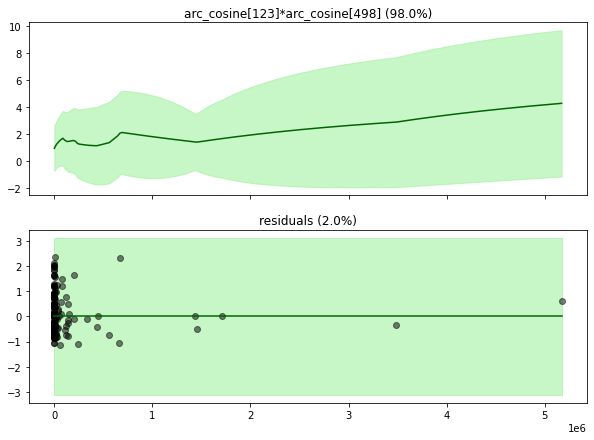

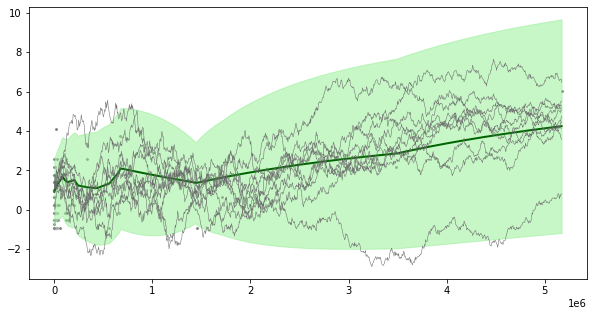

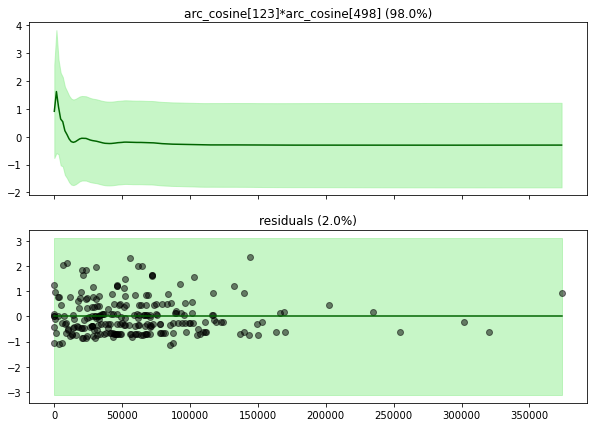

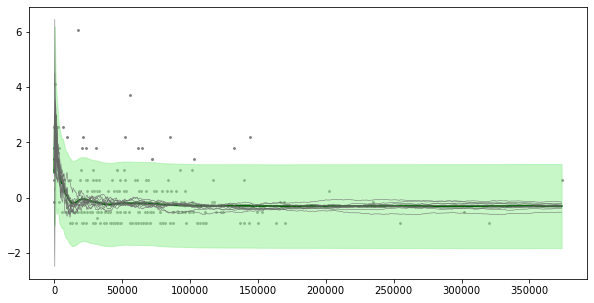

In [14]:
# Print resulting decomposition
print('Metabolite 123')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=123)
gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=123, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

print('Metabolite 498')
pred_kernel_parts(hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1],
                  'arc_cosine[123]*arc_cosine[498]',
                  x_idx=498)

gp_predict_fun(
    hbi_model[0]['arc_cosine[123]*arc_cosine[498]'][1], 
    x_idx=498, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)


In [18]:
# Which metabolites are these?
df.drop(['id', 'hbi'], axis=1).columns[[123, 498]]

Index(['C38:3 PC', 'cortisol'], dtype='object')

In [4]:
int_model = gpflow.models.GPR(
    data=(df[['C38:3 PC', 'cortisol']].fillna(0).to_numpy().reshape(-1, 2),
          df.hbi.to_numpy().reshape(-1, 1)),
    kernel=gpflow.kernels.ArcCosine(active_dims=[0])*gpflow.kernels.ArcCosine(active_dims=[1]),
    mean_function=gpflow.mean_functions.Constant())

opt_results = gpflow.optimizers.Scipy().minimize(
                int_model.training_loss,
                int_model.trainable_variables)

In [5]:
int_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[8.89900516]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,12.997128050057611
GPR.kernel.kernels[0].bias_variance,Parameter,Softplus,,True,(),float64,21.246525691023113
GPR.kernel.kernels[0].weight_variances,Parameter,Softplus,,True,(),float64,3.768662316411443e-12
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,12.997128050080763
GPR.kernel.kernels[1].bias_variance,Parameter,Softplus,,True,(),float64,5.864056279920286
GPR.kernel.kernels[1].weight_variances,Parameter,Softplus,,True,(),float64,0.00013386546254106477
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,3.853896225206588


<AxesSubplot:>

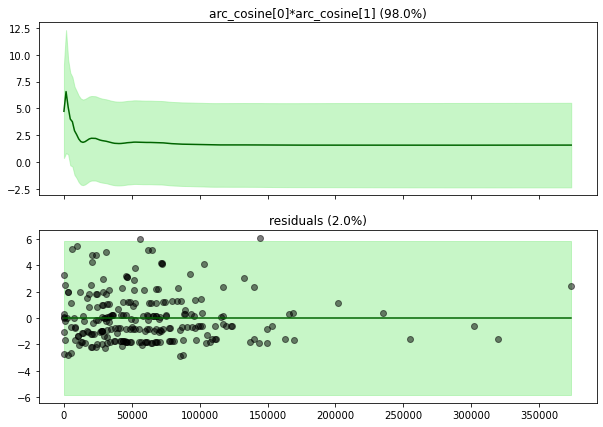

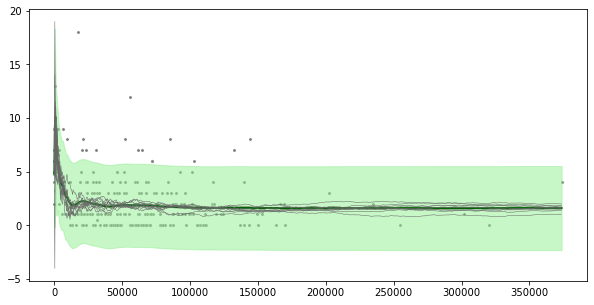

In [6]:
pred_kernel_parts(int_model,
#                   'squared_exponential[0]*squared_exponential[1]',
                  'arc_cosine[0]*arc_cosine[1]',
                  x_idx=1)

gp_predict_fun(
    int_model, 
    x_idx=1, 
    unit_idx=0,
    unit_label=10,
    num_funs=10
)

In [69]:
'*' in 'arc_cosine[0]*arc_cosine[1]'

True

In [63]:
x1 = np.linspace(0, df['C38:3 PC'].max(), num=100).round(0)
x2 = np.linspace(0, df['cortisol'].max(), num=100).round(0)
x_new = np.array(
    np.meshgrid(
        x1, x2
    )
).T.reshape(-1, 2)

mean_y, var_y = int_model.predict_y(
    Xnew = x_new
)

In [101]:
var_y

<tf.Tensor: shape=(10000, 1), dtype=float64, numpy=
array([[4.89433849],
       [5.12543689],
       [4.39932493],
       ...,
       [7.77666255],
       [7.77725733],
       [7.77784009]])>

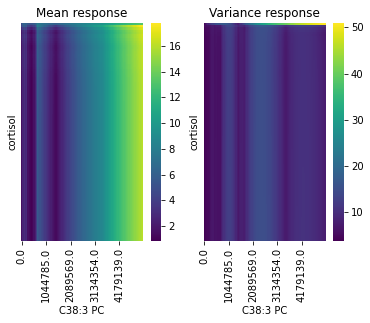

In [109]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

sns.heatmap(pd.DataFrame({'mean':mean_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'mean'),
           xticklabels=20,
           yticklabels=20,
           cmap='viridis',
           ax=ax1)
ax1.set_title('Mean response')
sns.heatmap(pd.DataFrame({'var':var_y.numpy().flatten(), 
              'cortisol': x_new[:,1].flatten(), 
              'C38:3 PC': x_new[:,0].flatten()}).pivot('cortisol', 'C38:3 PC', 'var'),
           xticklabels=20,
           yticklabels=False,
           cmap='viridis',
           ax=ax2)
ax2.set_title('Variance response')

plt.show()

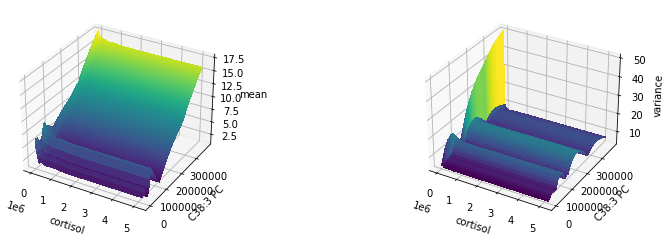

In [126]:
from mpl_toolkits.mplot3d import Axes3D
x1_, x2_ = np.meshgrid(x1, x2)


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

# Mean response
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
ax.plot_surface(x1_, x2_, mean_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('mean')

# Variance response
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(x1_, x2_, var_y.numpy().reshape(x1_.shape), 
                rstride=1, cstride=1, cmap='viridis',
                linewidth=0, antialiased=False)
ax.set_ylabel('C38:3 PC')
ax.set_xlabel('cortisol')
ax.set_zlabel('variance')
plt.show()

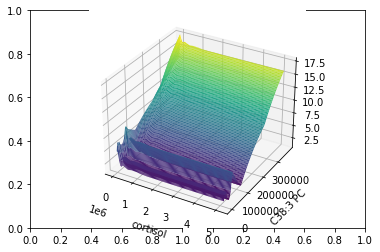

In [111]:
from mpl_toolkits.mplot3d import Axes3D

x1_, x2_ = np.meshgrid(x1, x2)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

ax1 = plt.axes(projection='3d')
ax1.plot_surface(x1_, x2_, 
                mean_y.numpy().reshape(x1_.shape), 
                rstride=1, 
                cstride=1,
                cmap='viridis', 
                edgecolor='none')
ax1.set_ylabel('C38:3 PC')
ax1.set_xlabel('cortisol');

In [70]:
%%time
hbi_model2 = full_kernel_search(
    X=df.drop(['hbi'], axis=1).fillna(0).to_numpy().reshape(-1, 553),
    Y=df[['hbi']].to_numpy().reshape(-1, 1),
    kern_list=[gpflow.kernels.ArcCosine()],
    cat_vars=[0],
    max_depth=3,
    early_stopping=True,
    prune=True,
    keep_all=False,
    lik='gaussian',
    verbose=False
)

Optimization not successful, skipping.
arc_cosine[124]*arc_cosine[499]
CPU times: user 2h 56min 17s, sys: 15min 32s, total: 3h 11min 50s
Wall time: 1h 59min 39s
